In [18]:
import torch
import evaluate

import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForCausalLM, pipeline
from torch import nn

from src.data_utils import clean_string, TextDataset, collate_fn
from src.lstm_model import LSTM
from src.lstm_train import train_model
from src.eval import compute_rouge_trans

ImportError: cannot import name 'compute_rouge_trans' from 'src.eval' (e:\DS\HM\yandex\tweets\src\eval.py)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используем {device}')

Используем cuda


### Этап 1. Сбор и подготовка данных
#### Загрузка, очистка, токенизация датасета

In [3]:
with open('data/tweets.txt', 'r', encoding='utf-8') as f:
    texts = f.readlines()

df = pd.DataFrame({'text': texts}) # [:1000]

In [4]:
df['clean_text'] = [clean_string(text) for text in tqdm(df['text'])]
df = df[df['clean_text'].str.len() > 0].reset_index(drop=True)

100%|██████████| 1600498/1600498 [00:55<00:00, 28969.14it/s]


In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenized_lengths = []
for text in df['clean_text'].head(10000):
    tokens = tokenizer.tokenize(text)
    tokenized_lengths.append(len(tokens))

MAX_LENGTH = int(np.percentile(tokenized_lengths, 90))

encoded = tokenizer(
    df['clean_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
    )

#### Разделение на train, val, test

In [6]:
train_ids, temp_ids, train_mask, temp_mask = train_test_split(
    encoded['input_ids'], 
    encoded['attention_mask'], 
    test_size=0.2, 
    random_state=42
)

val_ids, test_ids, val_mask, test_mask = train_test_split(
    temp_ids, 
    temp_mask, 
    test_size=0.5, 
    random_state=42
)

#### Создание dataset и dataloader

In [ ]:
BATCH_SIZE = 256

train_dataset = TextDataset(train_ids, train_mask)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

val_dataset = TextDataset(val_ids, val_mask)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

test_dataset = TextDataset(test_ids, test_mask)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 1277808
Val: 159726
Test: 159726


### Этап 2. Реализация рекуррентной сети

In [8]:
model = LSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_size=128, 
            num_layers=2, bidirectional=False, pad_idx=tokenizer.pad_token_id)
model.to(device)

LSTM(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=30522, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

100%|██████████| 624/624 [04:08<00:00,  2.51it/s]


Epoch: 0 | Train loss: 6.07257738795418 | Train rouge1: 0.02436750582517172 | Train rouge2: 0.00045839343719320284

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: have to go
    Правильно: work tired



100%|██████████| 624/624 [04:07<00:00,  2.52it/s]


Epoch: 1 | Train loss: 5.622096521063493 | Train rouge1: 0.029172794486926196 | Train rouge2: 0.0005750781287713271

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: buy my sisters
    Правильно: work tired



100%|██████████| 624/624 [04:06<00:00,  2.53it/s]


Epoch: 2 | Train loss: 5.515920863510707 | Train rouge1: 0.03229791535677436 | Train rouge2: 0.0008168628018897836

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: school i can
    Правильно: work tired



100%|██████████| 624/624 [04:03<00:00,  2.57it/s]


Epoch: 3 | Train loss: 5.457675847774133 | Train rouge1: 0.033742801653913634 | Train rouge2: 0.0008101465609698268

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: a sad place
    Правильно: work tired



100%|██████████| 624/624 [04:00<00:00,  2.59it/s]


Epoch: 4 | Train loss: 5.420241217296093 | Train rouge1: 0.03527638080965971 | Train rouge2: 0.0008909513345380596

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: the up with
    Правильно: work tired



100%|██████████| 624/624 [04:02<00:00,  2.57it/s]


Epoch: 5 | Train loss: 5.393099845410922 | Train rouge1: 0.03621146494307001 | Train rouge2: 0.0009402737287939943

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: return yet
    Правильно: work tired



100%|██████████| 624/624 [04:08<00:00,  2.51it/s]


Epoch: 6 | Train loss: 5.371723307726475 | Train rouge1: 0.03750388657468273 | Train rouge2: 0.0011039821012179475

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: aberdeen for church
    Правильно: work tired



100%|██████████| 624/624 [04:03<00:00,  2.56it/s]


Epoch: 7 | Train loss: 5.354903234407688 | Train rouge1: 0.03756470753319212 | Train rouge2: 0.0011207727035178398

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: bristol home
    Правильно: work tired



100%|██████████| 624/624 [04:24<00:00,  2.36it/s]


Epoch: 8 | Train loss: 5.340870964985627 | Train rouge1: 0.03799632345775939 | Train rouge2: 0.0011365138931739888

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: my main absolutely
    Правильно: work tired



100%|██████████| 624/624 [04:06<00:00,  2.53it/s]


Epoch: 9 | Train loss: 5.328762499376749 | Train rouge1: 0.03852465275185318 | Train rouge2: 0.0013757799759474593

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: work
    Правильно: work tired



100%|██████████| 624/624 [04:36<00:00,  2.26it/s]


Epoch: 10 | Train loss: 5.318609114163197 | Train rouge1: 0.039034784730984394 | Train rouge2: 0.0013396801810026905

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: car check
    Правильно: work tired



100%|██████████| 624/624 [04:20<00:00,  2.39it/s]


Epoch: 11 | Train loss: 5.309589632142049 | Train rouge1: 0.03966458972912664 | Train rouge2: 0.0018753003943692708

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: school work cr
    Правильно: work tired



100%|██████████| 624/624 [04:05<00:00,  2.54it/s]


Epoch: 12 | Train loss: 5.30133376413813 | Train rouge1: 0.039883047458335624 | Train rouge2: 0.0018322744759757957

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: the house tomorrow
    Правильно: work tired



100%|██████████| 624/624 [04:14<00:00,  2.46it/s]


Epoch: 13 | Train loss: 5.294197583618836 | Train rouge1: 0.04058488713866637 | Train rouge2: 0.0018595592047131197

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: tmorrow
    Правильно: work tired



100%|██████████| 624/624 [04:39<00:00,  2.24it/s]


Epoch: 14 | Train loss: 5.287580136209726 | Train rouge1: 0.04078407315425381 | Train rouge2: 0.0019886369598935486

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: sunset my pop
    Правильно: work tired



100%|██████████| 624/624 [04:39<00:00,  2.23it/s]


Epoch: 15 | Train loss: 5.281855682723033 | Train rouge1: 0.041158948336614015 | Train rouge2: 0.002005847327250938

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: potrise several
    Правильно: work tired



100%|██████████| 624/624 [04:39<00:00,  2.24it/s]


Epoch: 16 | Train loss: 5.276227083248206 | Train rouge1: 0.0406971443083286 | Train rouge2: 0.0020164463949527457

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: middlesbrough bmw in
    Правильно: work tired



100%|██████████| 624/624 [04:38<00:00,  2.24it/s]


Epoch: 17 | Train loss: 5.2714828335894985 | Train rouge1: 0.04092655590665693 | Train rouge2: 0.0019122397194290363

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: that session how
    Правильно: work tired



100%|██████████| 624/624 [04:39<00:00,  2.23it/s]


Epoch: 18 | Train loss: 5.266756226237003 | Train rouge1: 0.04132449567976591 | Train rouge2: 0.0021671420505942843

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: campus only cotton
    Правильно: work tired



100%|██████████| 624/624 [04:38<00:00,  2.24it/s]


Epoch: 19 | Train loss: 5.262513400174869 | Train rouge1: 0.042271812966280464 | Train rouge2: 0.0020588426657599745

  Примеры генерации:
    Промпт: [CLS] 3 day weekend over walking to work tired [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    Сгенерировано: the mall
    Правильно: work tired



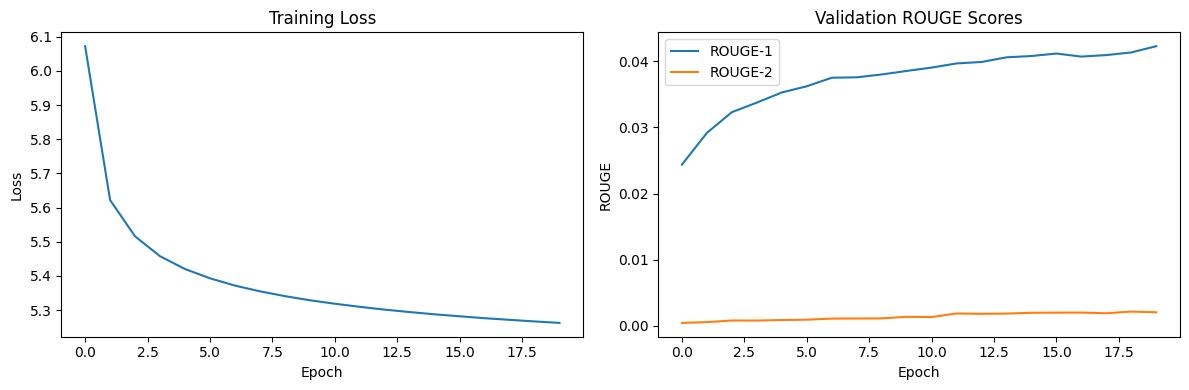

In [10]:
# Запускаем тренировку
train_losses, val_rouge = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    device=device,
    num_epochs=20,
)

# Визуализируем результаты
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
rouge1 = [s['rouge1'] for s in val_rouge]
rouge2 = [s['rouge2'] for s in val_rouge]
plt.plot(rouge1, label='ROUGE-1')
plt.plot(rouge2, label='ROUGE-2')
plt.title('Validation ROUGE Scores')
plt.xlabel('Epoch')
plt.ylabel('ROUGE')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [14]:
from src.eval_lstm import compute_rouge_metrics

model.eval()

test_results, test_predictions, test_targets = compute_rouge_metrics(
    model=model,
    dataloader=test_loader,  # test_loader
    tokenizer=tokenizer,
    device=device,
    max_new_tokens=15
)

print(f"Test ROUGE-1: {test_results['rouge1']:.4f}")
print(f"Test ROUGE-2: {test_results['rouge2']:.4f}")

100%|██████████| 624/624 [04:13<00:00,  2.46it/s]


Test ROUGE-1: 0.0415
Test ROUGE-2: 0.0020


In [41]:
import random

num_examples = min(5, len(test_predictions))
indices = random.sample(range(len(test_predictions)), num_examples)

for idx, i in enumerate(indices):
    print(idx+1, f"создано: {test_predictions[i]}")
    print(f"  таргет:    {test_targets[i]}")

1 создано: mom no
  таргет:    honey
2 создано: is
  таргет:    dont want either i want a
3 создано: cut cix
  таргет:    are you
4 создано: sun however you
  таргет:    melting pot
5 создано: out of
  таргет:    solid


#### Этап 4. Использование предобученного трансформера

In [ ]:
# 1) Загрузка токенизатора и модели
model_name = "distilgpt2"          # лёгкая версия GPT-2
tokenizer = AutoTokenizer.from_pretrained(model_name)
trans_model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
trans_model.to(device)

results, preds, targets = compute_rouge_trans(
    model=trans_model,
    tokenizer=tokenizer,
    dataloader=test_loader,
    device=device,
    max_new_tokens=15,
    top_p=0.95
)

Device set to use cuda
100%|██████████| 624/624 [27:37<00:00,  2.66s/it]


rouge1: 0.0022
rouge2: 0.0005
rougeL: 0.0022
rougeLsum: 0.0022
  начало: �gnideos half connect 50 App tests Museuminese spot amountensiveataague
  создано: artisans
  таргет: Donittenの futureremeimal�
  начало: �gnideos half connect 50 App tests Museuminese spot amountensiveataague
  создано: ": 5
  таргет: cutput interests�
  начало: �gnideos half connect 50 App tests Museuminese spot amountensiveataague
  создано: a-j
  таргет: conditions cut amount�
  начало: �gnideos half connect 50 App tests Museuminese spot amountensiveataague
  создано: torsion,
  таргет: ign experience incidentICitchlished######## Hel�
  начало: �gnideos half connect 50 App tests Museuminese spot amountensiveataague
  создано: cuz he
  таргет: mess mindput targetshood�


#### Этап 5. Формулирование выводов

Полученные результаты и там, и там сомнительные.  
И rouge1 и rouge2 лучше у lstm модели, хотя казалось бы, должно быть наоборот.  
При этом, очевидно, что lstm модель, обученная на 20 эпохах, далека от своих лучших результатов.  
Вероятно, distilgpt2 совершенно не знаком с манерой письма твиттов, и модель просто из коробки необходимо дообучать для получения достойного результата.